<font color=blue><b>Rodriguez Quintana Josue Daniel<br>
Matriculation number: 304121
    </b></font> 
# Seminar Data Analytics II: Recommender Systems
## Visual Bayesian Personalized Ranking from Implicit Feedback

<center><b>
Information Systems and Machine Learning Lab<br>
University of Hildesheim<br>
</b>
    <br>
    <br>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Universit%C3%A4t_Hildesheim_logo.svg/1200px-Universit%C3%A4t_Hildesheim_logo.svg.png" height="10%" width="10%">
</center>

This demo relies on the base code extracted from:
https://github.com/hello-dx/VBPR
Original author from the Tensorflow implementation:
hello-dx

In [8]:
# An implement of VBPR using tensorflow #
# 2018.11.19 #
import csv
import numpy as np
import random
import json
import tensorflow as tf
import random, string
import pickle

## Data extraction

In [9]:
def generateHashUser(size):
    #Generate a random hash user
    return ''.join(random.choices(string.ascii_uppercase + string.digits, k=size))


class Processing:
    def __init__(self, K, K2):
        self.R = []  # Rating matrix Train
        self.RTest = []  # Rating matrix Test
        self.nUsers = 0
        self.nItems = 0
        self.user_dict = {}
        self.item_dict = {}
        self.imageFeatures = {}
        self.imageFeaMatrix = []
        self.imageFeatureDim = 4096
        self.k = K   # Latent dimension
        self.k2 = K2  # Visual dimension # D
        self.MF_loss = 0

    # def load_data(self, image_feature_path, rating_file_path):
    #     # self.load_image_feature(image_feature_path)
    #     self.load_training_data(rating_file_path)

    def load_image_feature2(self, image_feature_path):
        csv_reader=csv.reader(open(image_feature_path))
        for item in csv_reader:
            item_id=item[0]
            item_feature = item[1:]
            item_feature = list(map(float, item_feature))
            self.imageFeatures[item_id] = item_feature
        self.imageFeaMatrix=[[0.]*self.imageFeatureDim]*self.nItems
        for item in self.imageFeatures:
            try:
                self.imageFeaMatrix[self.item_dict[item]] = self.imageFeatures[item]
            except:
                pass
    def load_image_feature(self, image_feature_path):
        with open ('img_featuresN.data', 'rb') as fp:
            newFeat = pickle.load(fp)
        #with open ('img_featuresN.data', 'rb') as fp:
        #    itemlist = pickle.load(fp)
            
        csv_reader=csv.reader(open(image_feature_path))
        for item in csv_reader:
            item_id=item[0]
            #item_feature = item[1:]
            #print(len(item_feature))
            #item_feature = list(map(float, item_feature))
            #print(len(item_feature))
            #self.imageFeatures[item_id] = item_feature
        self.imageFeaMatrix=[[0.]*self.imageFeatureDim]*self.nItems
        printOne= True
        iImg = -1
        for item in self.imageFeatures:
            iImg+=1
            try:
                if printOne:
                    print(type(self.imageFeatures[item]))
                    print(len(self.imageFeatures[item]))
                    print(self.imageFeatures[item])
                    printOne=False
                #self.imageFeaMatrix[self.item_dict[item]] = self.imageFeatures[item]
                self.imageFeaMatrix[self.item_dict[item]] = newFeat[iImg].reshape(-1,).tolist()
            except:
                pass            

    def load_training_data(self, rating_file_path):
        with open(rating_file_path,'r') as f:
            data = json.load(f)

        # create user/item idx dictionary
        for user_id in data:
            if user_id not in self.user_dict.keys():
                self.user_dict[user_id] = self.nUsers
                self.nUsers += 1
                for item_id in data[user_id]:
                    if item_id not in self.item_dict.keys():
                        self.item_dict[item_id] = self.nItems
                        self.nItems += 1
        self.R = np.array([[0.] * self.nItems] * self.nUsers)
        for user_id in data:
            for item_id in data[user_id]:
                self.R[self.user_dict[user_id], self.item_dict[item_id]] = 10 #data[user_id][item_id][1] #Fill with bias
    def load_training_test_data(self, rating_file_path,training_percentage=0.8):
        with open(rating_file_path,'r') as f:
            data = json.load(f)

        # create user/item idx dictionary
        for user_id in data:
            if user_id not in self.user_dict.keys():
                self.user_dict[user_id] = self.nUsers
                self.nUsers += 1
                #Add the items to the total items dictionary
                for item_id in data[user_id]:
                    if item_id not in self.item_dict.keys():
                        self.item_dict[item_id] = self.nItems
                        self.nItems += 1
        #Create a 0s filled array
        self.R = np.array([[0.] * self.nItems] * self.nUsers)
        #Create the test set.
        self.RTest = np.array([[0.] * self.nItems] * self.nUsers)        
        for user_id in data:
            #Shuffle the data
            rated_items = data[user_id]
            random.shuffle(rated_items) #shuffle items
            iTr = int(len(rated_items) * training_percentage)
            rated_items_train = rated_items[0:iTr-1]
            rated_items_test = rated_items[iTr:-1]
            for item_id in rated_items_train:
                self.R[self.user_dict[user_id], self.item_dict[item_id]] = 10 #data[user_id][item_id][1] 
                
            for item_id in rated_items_test:
                self.RTest[self.user_dict[user_id], self.item_dict[item_id]] = 10 #data[user_id][item_id][1]                 
    def add_user(self, items_feedback, user_id = None):
        #Generate a random user id
        if(user_id is None):
            user_id = generateHashUser(28)
            while user_id in self.user_dict.values():
                user_id = generateHashUser(28)

        self.user_dict[user_id] = self.nUsers
        self.nUsers += 1
        #Add the user to the end
        new_user = np.array([[0.] * self.nItems] * 1)
        print(new_user.shape)
        print(self.R.shape)
        self.R = np.vstack((self.R,new_user))
        print(self.R.shape)
        for item_id in items_feedback:
            self.R[self.user_dict[user_id], self.item_dict[item_id]] = 10 #data[user_id][item_id][1] 

In [10]:
model=Processing(K=64, K2=128)
#model.load_training_data('feedback_file.json')  ## feedback_file.json
model.load_training_test_data('feedback_file.json')  ## feedback_file.json


In [11]:
def get_variable(type, shape, mean, stddev, name):
    if type == 'W':
        var = tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                              initializer=tf.random_normal_initializer(mean=mean, stddev=stddev))
        tf.add_to_collection('regular_losses', tf.contrib.layers.l2_regularizer(0.005)(var))
        return var
    elif type == 'b':
        return tf.get_variable(name=name, shape=shape, dtype=tf.float32,
                               initializer=tf.zeros_initializer())


def VBPR(itemFea_matrix, userFea_matrix, user_idx, pos_item_idx, neg_item_idx,all_item_idx):
    MF_U = get_variable(type='W', shape=[model.nUsers, model.k], mean=0, stddev=0.01, name='MF_U')
    MF_I = get_variable(type='W', shape=[model.nItems, model.k], mean=0, stddev=0.01, name='MF_I')
    visual_U = get_variable(type='W', shape=[model.nUsers, model.k2], mean=0, stddev=0.01, name='visual_U')
    visual_I = itemFea_matrix

    MF_U_factor = tf.gather(MF_U, user_idx)
    
    MF_U_factor = tf.reshape(MF_U_factor, shape=[1, tf.shape(MF_U_factor)[0]])  ##[1, k]
    MF_I_factor_pos = tf.gather(MF_I, pos_item_idx)   ## [?, nItem]
    MF_I_factor_neg = tf.gather(MF_I, neg_item_idx)   ## [?, nItem]
    MF_I_factor_all = tf.gather(MF_I, all_item_idx)   ## [?, nItem] #For prediction
    
    #relatedItems = tf.multiply(MF_I,tf.transpose(MF_I_factor_all))
    #Vt = tf.transpose(MF_I_factor_all)
    #Vt =  tf.convert_to_tensor(tf.reshape(Vt, [-1,1]))
    Vt = MF_I_factor_all
    V = MF_I
    #relatedItems = tf.multiply(MF_I,Vt) # V*Vt
    
    visual_U_vector = tf.gather(visual_U, user_idx)
    visual_U_vector = tf.reshape(visual_U_vector, shape=[1, tf.shape(visual_U_vector)[0]])  ##[1, k2]
    visual_I_matrix_pos = tf.gather(visual_I, pos_item_idx)
    visual_I_matrix_neg = tf.gather(visual_I, neg_item_idx)
    visual_I_matrix_all = tf.gather(visual_I, all_item_idx) # For prediction

    #Encoded E
    itemEmb_W = get_variable(type='W', shape=[model.imageFeatureDim, model.k2], mean=0, stddev=0.01, name='itemEmb_W')
    #Bias for the visual factors
    itemEmb_b = get_variable(type='b', shape=[model.k2], mean=0, stddev=0.01, name='itemEmb_b')

    visual_U_factor = visual_U_vector
    visual_I_factor_pos = tf.sigmoid(tf.matmul(visual_I_matrix_pos, itemEmb_W) + itemEmb_b)
    visual_I_factor_neg = tf.sigmoid(tf.matmul(visual_I_matrix_neg, itemEmb_W) + itemEmb_b)
    visual_I_factor_all = tf.sigmoid(tf.matmul(visual_I_matrix_all, itemEmb_W) + itemEmb_b) # For prediction
    
    VV = tf.matmul(visual_I, itemEmb_W) + itemEmb_b # For visual elements
    VVt = visual_I_factor_all # Retrieve only the specified elements.
    
    BPR_user_factor = tf.concat([MF_U_factor, visual_U_factor], axis=1)
    
    BPR_item_factor_pos = tf.concat([MF_I_factor_pos, visual_I_factor_pos], axis=1)
    BPR_item_factor_neg = tf.concat([MF_I_factor_neg, visual_I_factor_neg], axis=1)
    BPR_item_factor_all = tf.concat([MF_I_factor_all, visual_I_factor_all], axis=1)# V for prediction
    
    
    uij = tf.multiply(BPR_user_factor, BPR_item_factor_pos)  # (?, concat_Dim)
    uik = tf.multiply(BPR_user_factor, BPR_item_factor_neg)  # (?, concat_Dim)
    prediction = uik #Until here the recommendation should be returned
    recommU = tf.multiply(BPR_user_factor, BPR_item_factor_all)  # (?, concat_Dim)
    
    
    uij = tf.sigmoid(tf.reshape(tf.reduce_sum(uij, axis=1), shape=[tf.shape(uij)[0], 1]))  # (?, 1)
    uik = tf.sigmoid(tf.reshape(tf.reduce_sum(uik, axis=1), shape=[tf.shape(uik)[0], 1]))  # (?, 1)

    uij_shape = tf.shape(uij)[0]
    uik_shape = tf.shape(uik)[0]
    uij = tf.tile(uij, [uik_shape, 1])
    uik = tf.reshape(tf.tile(uik, [1, uij_shape]), shape=[-1, 1])
    #Bprobability = tf.sigmoid(uij - uik)
    BPR_loss = tf.reduce_mean(-tf.log(tf.sigmoid(uij - uik)))
    AUC =  tf.reduce_mean(tf.to_float((uij - uik) > 0))
    return BPR_loss, uij, uik, prediction,recommU,V,Vt,VV,VVt,AUC

## K = 64,  D = 128

In [12]:
#model=Processing(K=64, K2=128)
#model.load_training_data('feedback_file.json')  ## feedback_file.json

model.load_image_feature('image_feature.csv')  ## image_feature.csv

itemFea_matrix = tf.placeholder(dtype=tf.float32, shape=[model.nItems, model.imageFeatureDim])
userFea_matrix = tf.placeholder(dtype=tf.float32, shape=[None, model.nItems])
user_idx = tf.placeholder(dtype=tf.int32, shape=[])
pos_item_idx = tf.placeholder(dtype=tf.int32, shape=[None,])
neg_item_idx = tf.placeholder(dtype=tf.int32, shape=[None,])
all_item_idx = tf.placeholder(dtype=tf.int32, shape=[None,])

In [13]:
print("Number of users: ",model.nUsers)
print("Number of items: ",model.nItems)

Number of users:  1000
Number of items:  9006


In [14]:
BPR_loss, uij, uik, prediction, recommU, V, Vt,VV,VVt,AUC= VBPR(itemFea_matrix, userFea_matrix, user_idx, pos_item_idx, neg_item_idx,all_item_idx)
#recommU = predictionUser(itemFea_matrix, userFea_matrix, user_idx, all_item_idx)
tf.add_to_collection('BPR_losses', BPR_loss)
regular_loss = tf.add_n(tf.get_collection('regular_losses'))
loss = BPR_loss #+ regular_loss

accuracy = tf.reduce_sum(tf.round(tf.sigmoid(uij - uik)))/tf.reduce_sum(tf.ceil(tf.sigmoid(uij - uik)))

global_step = tf.Variable(0, dtype=tf.int64, name='global_step', trainable=False)
learning_rate = tf.train.exponential_decay(0.001, global_step, decay_steps=1000, decay_rate=0.85, staircase=False)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

sess=tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(max_to_keep=3)
devices = sess.list_devices()

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

print(devices)

Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15029687149506068307
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3966759356911993027
physical_device_desc: "device: XLA_CPU device"
]
[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 18391860224064930150), _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17796058083264164010)]


In [22]:
def splitTrainingTest(nUsers,testSize):
    #Create two lists with data for training and for testing 
    training = set(range(nUsers))
    test = set(random.sample(training,int(testSize*len(training))))
    training = training.difference(test)
    return list(training), list(test)
#trainUsers, testUsers = splitTrainingTest(model.nUsers,0.05)

In [27]:
import os
import datetime
import time

logs_base_dir = 'logs' + '/train_{}'.format(datetime.datetime.utcnow().strftime("%Y%m%d%H%M%S")) #To create a new folder in each execution.
os.makedirs(logs_base_dir, exist_ok=True)
file_writer = tf.summary.FileWriter(logs_base_dir, sess.graph)
print("tensorboard --logdir="+logs_base_dir+" --port 6006")

tensorboard --logdir=logs/train_20200307130819 --port 6006


In [28]:
def sampleNegativeItems(all_items, positive_feedback, sample_size):
    #Gets N samples not included in the positive_feedback list
    non_seen_items = all_items.difference(set(positive_feedback))
    return list(random.sample(non_seen_items, sample_size))

In [29]:

all_items = set(range(model.nItems))

loss_training_hist = {}

max_acc = 0

print("Starting training...")
training_start_time = time.time()
ntestUsers = int(model.nUsers*0.02)

for step in range(15001):
    user_i = random.randint(0, model.nUsers-1)
    #user_i = random.randint(0, len(trainUsers)-1)
    #user_i = trainUsers[user_i]
    
    step_now = step
    #create positive & negative item
    pos_item = [x for x in range(model.nItems) if model.R[user_i][x] != 0]
    neg_item = []
    #neg_item = sampleNegativeItems(all_items, pos_item, sample_size=5 * len(pos_item))
    #neg_item = sampleNegativeItems(all_items, pos_item, sample_size=5 * len(pos_item))
    #neg_item = sampleNegativeItems(all_items, pos_item, sample_size=50)


    if step_now % 50 == 0:
        neg_item = sampleNegativeItems(all_items, pos_item, sample_size=5 * len(pos_item))
        
        _, los, B_loss, l2_loss, acc, uijj,AUC_score= sess.run([train_step, loss, BPR_loss, regular_loss, accuracy, uij,AUC],
                              feed_dict={itemFea_matrix: model.imageFeaMatrix,
                                         userFea_matrix: model.R,
                                         user_idx: user_i,
                                         pos_item_idx: pos_item,
                                         neg_item_idx: neg_item,
                                         global_step: step_now})
        print('Epoch-%d, Loss: %f, AUC : %f.'%(step_now, los, AUC_score))
        summary = tf.Summary(value=[tf.Summary.Value(tag="AUC", simple_value=AUC_score)]) #Convert to tensorflow object
        file_writer.add_summary(summary=summary, global_step=step_now)
        summary = tf.Summary(value=[tf.Summary.Value(tag="loss_training", simple_value=los)]) #Convert to tensorflow object
        file_writer.add_summary(summary=summary, global_step=step_now)
    else:
        neg_item = sampleNegativeItems(all_items, pos_item, sample_size=1)
        #Update parameters without calculating further things
        _= sess.run([train_step],
          feed_dict={itemFea_matrix: model.imageFeaMatrix,
                     userFea_matrix: model.R,
                     user_idx: user_i,
                     pos_item_idx: pos_item,
                     neg_item_idx: neg_item,
                     global_step: step_now})        
        
        
    if step_now % 100 == 0 and step_now>0:
        final_acc = 0
        #for i in range(model.nUsers):
        final_loss = 0
        final_auc = 0
        testUsers = random.sample(range(0, model.nUsers),ntestUsers)
        #print("TEST USERS: ")
        #print(testUsers)
        for i in testUsers:
            valid_pos_item = [x for x in range(model.nItems) if model.RTest[i][x] != 0]
            #IMPORTANT: Not consider the training items which are valid into the negative items search!
            valid_pos_itemTr = [x for x in range(model.nItems) if model.R[i][x] != 0]
            allPositive = valid_pos_item + valid_pos_itemTr
            
            valid_neg_item = sampleNegativeItems(all_items, allPositive, sample_size=5 * len(valid_pos_item))
            #valid_neg_item = sampleNegativeItems(all_items, valid_pos_item, sample_size=500)
            valid_los, valid_acc,AUC_score = sess.run([loss, accuracy,AUC],
                                            feed_dict={itemFea_matrix: model.imageFeaMatrix,
                                                       userFea_matrix: model.RTest,
                                                       user_idx: i,
                                                       pos_item_idx: valid_pos_item,
                                                       neg_item_idx: valid_neg_item})
            final_acc += valid_acc
            final_loss += valid_los
            final_auc += AUC_score
        final_acc = final_acc / ntestUsers
        final_loss = final_loss / ntestUsers
        final_auc = final_auc / ntestUsers
        #print('AUC = %f' % (final_auc))
        print('Test Loss = %f , Test AUC= %f' % (final_loss,final_auc))
        summary = tf.Summary(value=[tf.Summary.Value(tag="AUC_test", simple_value=final_auc)]) #Convert to tensorflow object
        file_writer.add_summary(summary=summary, global_step=step_now)
        summary = tf.Summary(value=[tf.Summary.Value(tag="loss_test", simple_value=final_loss)]) #Convert to tensorflow object
        file_writer.add_summary(summary=summary, global_step=step_now)        
        
        if final_auc > max_acc:
            max_acc = final_auc
        print('saving model. AUC = %f'%(final_auc))
        saver.save(sess, './model/model_%f.ckpt' % (final_auc), global_step=step_now)
        
#print('saving final model. Accuracy = %f'%(final_acc))
#saver.save(sess, './model/model_%f.ckpt' % (final_acc), global_step=step_now)
print("Training finished, time {:.2f} seconds".format(time.time() - training_start_time))

Starting training...
Epoch-0, Loss: 0.684051, AUC : 1.000000.
Epoch-50, Loss: 0.693165, AUC : 0.461728.
Epoch-100, Loss: 0.691705, AUC : 0.994444.
Test Loss = 0.693186 , Test AUC= 0.518125
saving model. AUC = 0.518125
Epoch-150, Loss: 0.692306, AUC : 1.000000.
Epoch-200, Loss: 0.692961, AUC : 0.875000.
Test Loss = 0.693116 , Test AUC= 0.547500
saving model. AUC = 0.547500
Epoch-250, Loss: 0.669948, AUC : 1.000000.
Epoch-300, Loss: 0.693030, AUC : 0.662500.
Test Loss = 0.693277 , Test AUC= 0.420000
saving model. AUC = 0.420000
Epoch-350, Loss: 0.692684, AUC : 0.987500.
Epoch-400, Loss: 0.672541, AUC : 1.000000.
Test Loss = 0.693151 , Test AUC= 0.544167
saving model. AUC = 0.544167
Epoch-450, Loss: 0.684371, AUC : 1.000000.
Epoch-500, Loss: 0.665130, AUC : 1.000000.
Test Loss = 0.693122 , Test AUC= 0.571667
saving model. AUC = 0.571667
Epoch-550, Loss: 0.691797, AUC : 0.966942.
Epoch-600, Loss: 0.650249, AUC : 1.000000.
Test Loss = 0.693107 , Test AUC= 0.549444
saving model. AUC = 0.5494

In [30]:
from IPython.display import IFrame

IFrame(src='http://localhost:6006', width=1200, height=600)

In [32]:
import json
fileItems = 'items.json'
with open(fileItems) as items_file:
    items_dict = json.load(items_file)

items_list = list(items_dict.values())
print(len(items_list))
for i in range(20):
    print(items_list[i])
#user_ids_json= json.dumps(list)
dictOfItemsProduction = { items_list[i] : i for i in range(0, len(items_list) ) }
listObservedObjects = ["B00YGORRT8","B073RCT25C","B00EFCZRWU"]
idItem = dictOfItemsProduction["B073RCT25C"]
observedItems = [dictOfItemsProduction.get(key) for key in listObservedObjects]
print(observedItems)

9006
B015G2E9LW
B00O3OSIIK
B00GXM5VDA
B00HWFCFPO
B005GPJ582
B0106XJVCS
B00PYXP4Y0
B01M69DNJG
B01D9JMF2E
B074JDN4N8
B0059DS9K6
B078X6WDQX
B06Y4HTQYX
B01GCFJQ0G
B00KXQYSXQ
B07GCJ2MR4
B01A6MCLE4
B06VVZWVHQ
B01CGV1GYO
B01934K2LU
[5786, 5809, 5784]


Visualizer of product images

In [33]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from os import path

def showImagesHorizontally(list_of_files,prob,dim):
    if(dim):
        fig = figure(figsize=dim)
    else:
        fig = figure(figsize=(20,80))
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        if prob:
            caption = round(prob[i],5)
            a.title.set_text(caption)
        image = imread(list_of_files[i])
        imshow(image,cmap='Greys_r')
        axis('off')
def showAllImagesH(imageList,probabilities=None,dim=None):
    imageFiles= []
    prob = []
    it= 0
    for productID in imageList:
        url = 'productImages/'+productID+'.jpg'
        if(path.exists(url)):
            imageFiles.append(url)
            if probabilities:
                prob.append(probabilities[it])
        it+=1
    if probabilities is None:
        prob = None
    showImagesHorizontally(imageFiles,prob,dim=dim)
imageList = ["B00YGORRT8","B073RCT25C","B00EFCZRWU"]
imageList = ["B00YGORRT8","B073RCT25C","B00EFCZRWU"]
pinkItems = []
for code in imageList:
    pinkItems.append(dictOfItemsProduction[code])
print(pinkItems)
#showAllImagesH(imageList)

[5786, 5809, 5784]



INFO:tensorflow:Restoring parameters from ./model/model_0.540833.ckpt-15000
USER:  156
Because you have seen these items:
VBPR recommends you: 


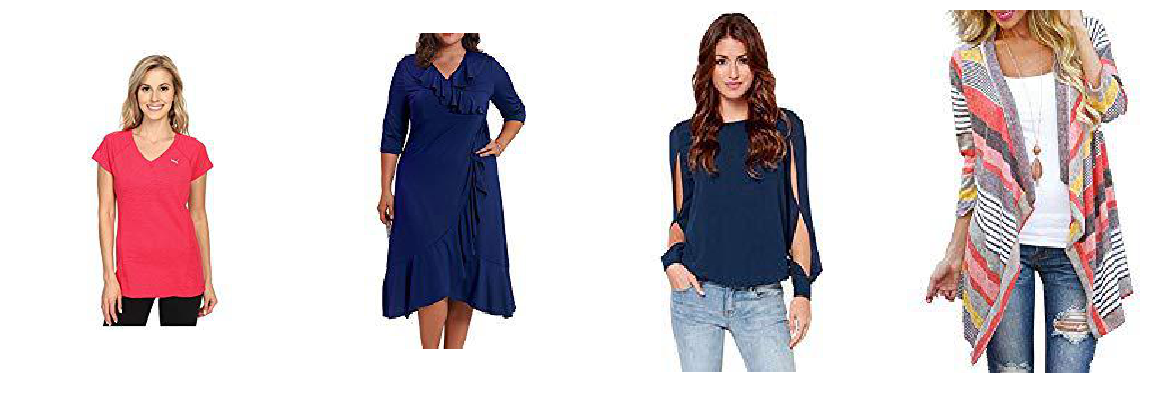

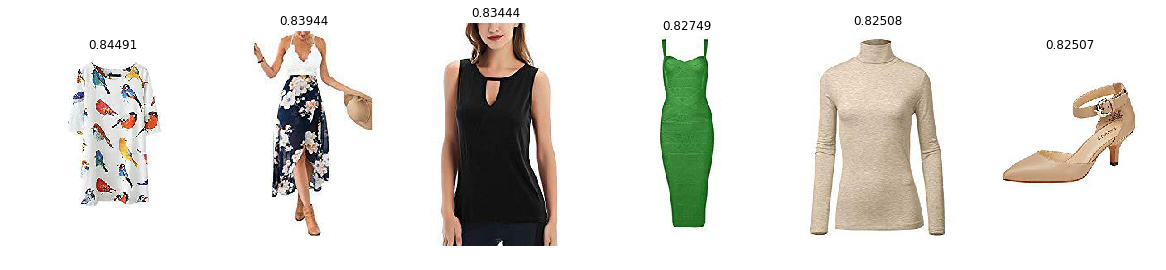

In [63]:
from random import randrange
all_items = set(range(model.nItems))
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-(x)))
savedModelMeta= "./model/model_0.892626.ckpt-4800.meta"
savedModel= "./model/model_0.892626.ckpt-4800.meta"
ckpt_dir = "./model/"


#Read JSON of articles and map to the id of each article
print("")
with tf.Session() as sess:
    
    #saver = tf.train.import_meta_graph(saveiRecommendedItems[i]dModelMeta)
    #saver.restore(sess, savedModel)
    saver.restore(sess,tf.train.latest_checkpoint(ckpt_dir)) 
    
    final_acc = 0
    #for i in range(model.nUsers):
    ntestUsers = 1
    #testUsers = random.sample(range(model.nUsers, ntestUsers))
    #print("TEST USERS: ")
    #print(testUsers)
    userToTest = randrange(model.nUsers)
    userToTest = 156
    print("USER: ",userToTest)
    valid_pos_item = [x for x in range(model.nItems) if model.R[userToTest][x] != 0]
    #print(len(valid_pos_item))
    valid_neg_item = []
    #valid_neg_item = sampleNegativeItems(all_items, valid_pos_item, sample_size=50 * len(valid_pos_item))
    valid_neg_item = sampleNegativeItems(all_items, valid_pos_item, sample_size=5000)
    valid_all_item = valid_neg_item
    #print(len(valid_pos_item))
    #print(len(valid_neg_item))
    
    valid_los, valid_acc, uijj,uikk,pred,recommendationU= sess.run([loss, accuracy, uij,uik,prediction,recommU],
                                    feed_dict={itemFea_matrix: model.imageFeaMatrix,
                                               userFea_matrix: model.R,
                                               user_idx: userToTest,
                                               pos_item_idx: valid_pos_item,
                                               neg_item_idx: valid_neg_item,
                                               all_item_idx: valid_all_item})
    final_acc += valid_acc
    #print('Test Accuracy = %f' % (final_acc / ntestUsers))
    result = np.subtract(uijj, uikk)
    
    #accuracy = tf.reduce_sum(tf.round(tf.sigmoid(uij - uik)))/tf.reduce_sum(tf.ceil(tf.sigmoid(uij - uik)))
    result = result.reshape((len(valid_neg_item),len(valid_pos_item)))
    result = sigmoid(np.sum(result,axis=1)) #Sigmoid to get the probabilities from 0 to 1
    #result = np.sum(result,axis=1) #Sigmoid to get the probabilities from 0 to 1
    #print(result.shape)
    #print(result[:10])
    recommendedItems = result
    
    
    recommendedItems2 = sigmoid(np.sum(recommendationU,axis=1)) #Sigmoid to get the probabilities from 0 to 1
    #Get the top 10 - note that argsort returns the index of the sorted list, whereas [::-1] reverses the order to get the maximum probale items. 
    #[:10] selects only the first 10 elements
    showOnly = 6
    
    iRecommendedItems = np.argsort(recommendedItems)[::-1][:showOnly] 
    #print("Top ",showOnly)
    #print(recommendedItems[:showOnly] )
    #print(iRecommendedItems)
    
    realRecommendedItems = []
    probRecommendation = []
    for i in range(showOnly):
        #print(recommendedItems[iRecommendedItems[i]],"-")
        probRecommendation.append(recommendedItems[iRecommendedItems[i]])
        vNi = valid_neg_item[iRecommendedItems[i]] #Non seen item numerical id
        idIRec = items_list[vNi] # Get the ID as text->dabatase id
        realRecommendedItems.append(idIRec)
        
    #print(realRecommendedItems)
    #Positive feedback items, limit to 10
    realSeenItems = []
    
    for i in range(showOnly):
        if(i < len(valid_pos_item)):
            vNi=valid_pos_item[i]
            realSeenItems.append(items_list[vNi])
    print("Because you have seen these items:")
    showAllImagesH(realSeenItems)
    print("VBPR recommends you: ")
    showAllImagesH(realRecommendedItems,probRecommendation)
    

## References: 
- VBPR, original repository: https://github.com/hello-dx/VBPR
- https://stackoverflow.com/questions/36006136/how-to-display-images-in-a-row-with-ipython-display